In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [2]:
now = datetime.now()

before = now -relativedelta(years=10)

now_day = now.strftime("%Y-%m-%d")
before_day = before.strftime("%Y-%m-%d")
print(f"end : {now_day}")
print(f"start : {before_day}")

samsung_stock = pdr.get_data_yahoo("005930.KS", start=before_day, end=now_day)
print(samsung_stock)

end : 2022-11-01
start : 2012-11-01
[*********************100%***********************]  1 of 1 completed
               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2012-11-01  25900.0  26040.0  25800.0  25940.0  20755.191406  10455600
2012-11-02  26380.0  26660.0  26260.0  26540.0  21235.265625  18521400
2012-11-05  26560.0  26980.0  26400.0  26820.0  21459.304688  13062050
2012-11-06  26980.0  26980.0  26640.0  26980.0  21587.328125   8981800
2012-11-07  26860.0  27240.0  26700.0  27240.0  21795.357422   9676400
...             ...      ...      ...      ...           ...       ...
2022-10-25  57000.0  58600.0  57000.0  57700.0  57700.000000  17405678
2022-10-26  58000.0  59600.0  57700.0  59400.0  59400.000000  20824967
2022-10-27  59700.0  60100.0  58900.0  59500.0  59500.000000  21756712
2022-10-28  58900.0  59200.0  57200.0  57300.0  57300.000000  20924937
2022-10-31  58100.0  59900.0  58000.0  5940

In [3]:
close_prices = samsung_stock['Close'].values
print(close_prices)

windown_size = 30

result_list = []
for i in range(len(close_prices)-(windown_size+1)):
  result_list.append(close_prices[i:i+(windown_size+1)])

normal_data = []
for window in result_list:
  window_list = [((float(p) / float(window[0]))-1)for p in window]
  normal_data.append(window_list)

result_list = np.array(normal_data)
print(result_list.shape[0], result_list.shape[1])

[25940. 26540. 26820. ... 59500. 57300. 59400.]
2424 31


In [4]:
row = int(round(result_list.shape[0]*0.9))
train = result_list[:row,:]

x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = train[:,-1]

x_test = result_list[row:,:-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result_list[row:,-1]

x_train.shape, x_test.shape

((2182, 30, 1), (242, 30, 1))

In [6]:
model = Sequential()
model.add(LSTM(windown_size, return_sequences=True, input_shape=(windown_size, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 30)            3840      
                                                                 
 lstm_2 (LSTM)               (None, 64)                24320     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=10)
model.save(r'./samsung.h5')

Epoch 1/10
219/219 [==============================] - 4s 10ms/step - loss: 9.5305e-04 - val_loss: 3.5874e-04
Epoch 2/10
219/219 [==============================] - 2s 8ms/step - loss: 5.1772e-04 - val_loss: 5.0401e-04
Epoch 3/10
219/219 [==============================] - 2s 8ms/step - loss: 3.7181e-04 - val_loss: 2.1983e-04
Epoch 4/10
219/219 [==============================] - 2s 8ms/step - loss: 3.2543e-04 - val_loss: 1.9857e-04
Epoch 5/10
219/219 [==============================] - 2s 8ms/step - loss: 3.1283e-04 - val_loss: 5.9665e-04
Epoch 6/10
219/219 [==============================] - 2s 8ms/step - loss: 3.1137e-04 - val_loss: 2.7877e-04
Epoch 7/10
219/219 [==============================] - 2s 8ms/step - loss: 3.1201e-04 - val_loss: 1.8851e-04
Epoch 8/10
219/219 [==============================] - 2s 9ms/step - loss: 3.0902e-04 - val_loss: 4.4236e-04
Epoch 9/10
219/219 [==============================] - 2s 8ms/step - loss: 3.0525e-04 - val_loss: 1.8380e-04
Epoch 10/10
219/219 [======

8/8 [==============================] - 0s 3ms/step


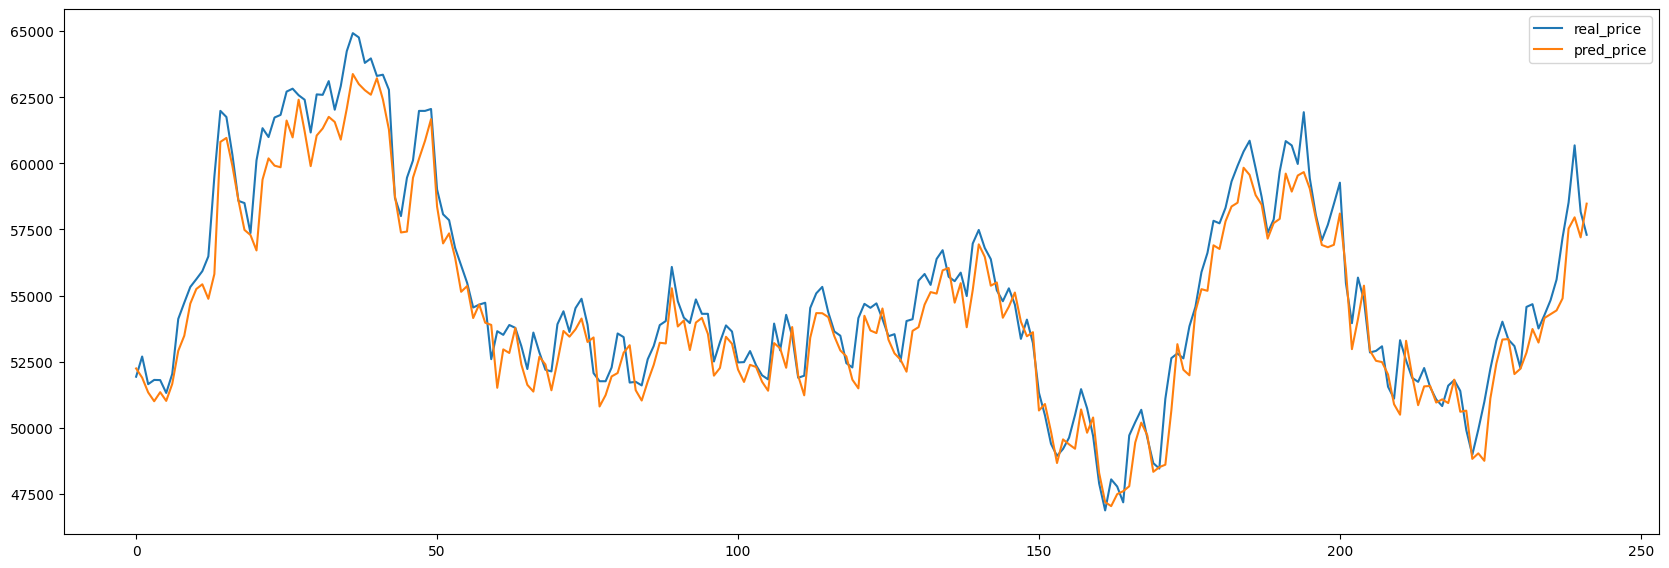

In [8]:
pred = model.predict(x_test)

pred_price = []
for i in pred:
  pred_price.append((i+1)* window[0])

real_price = []
for i in y_test:
  real_price.append((i+1)*window[0])

fig = plt.figure(facecolor='white', figsize=(70,15))
ax = fig.add_subplot(234)
ax.plot(real_price, label='real_price')
ax.plot(pred_price, label='pred_price')
ax.legend()
plt.show()